In [1]:
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

In [2]:
DATA_DIR = "data"
IMAGE_TEST_DIR = "images_prepped_test"
IMAGE_TRAIN_DIR = "images_prepped_train"
ANNO_TEST_DIR = "annotations_prepped_test"
ANNO_TRAIN_DIR = "annotations_prepped_train"


In [3]:
IMAGE_TRAIN_PATH = os.path.join(DATA_DIR, IMAGE_TRAIN_DIR)
image_train_filelist = [os.path.join(IMAGE_TRAIN_PATH, filename) for filename in os.listdir(IMAGE_TRAIN_PATH)]
ANNO_TRAIN_PATH = os.path.join(DATA_DIR, ANNO_TRAIN_DIR)
anno_train_filelist = [os.path.join(ANNO_TRAIN_PATH, filename) for filename in os.listdir(ANNO_TRAIN_PATH)]

In [4]:
import os
import tensorflow as tf
from  tensorflow.keras import models

In [5]:
model_filepath = os.path.join(
    "model_repo", "unet_256_model.json"
)
# Reload the model from the json file
with tf.device('/cpu:0'):
    with open(model_filepath) as json_file:
        json_config = json_file.read()
    model = models.model_from_json(json_config)
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [6]:
high_accuracy_weight_path = os.path.join("weights", "best_weights.hdf5")
model.load_weights(high_accuracy_weight_path)

In [7]:
BASE_SIZE =256
img = image_train_filelist[0]

img = cv2.imread(img)
img = cv2.resize(img, (BASE_SIZE, BASE_SIZE))
img.shape

(256, 256, 3)

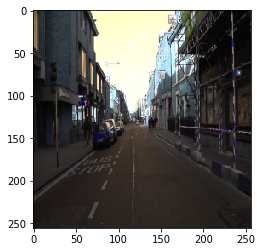

In [8]:
plt.imshow(img, interpolation='nearest')
plt.show()

In [9]:
def get_npy(filelist):
    result = []
    for filename in filelist:
        img = cv2.imread(filename)
        img = cv2.resize(img, (BASE_SIZE, BASE_SIZE))
        result.append(img)    
    return np.array(result)

In [10]:
batch_img = get_npy(image_train_filelist[:4])
result = model.predict(batch_img)
result_one = result[0].argmax(axis=2)
# result_one = np.array([result_one, result_one, result_one])
# result_one = np.repeat(result_one[:, :, np.newaxis], 3, axis=2)

In [11]:
stacked_img = np.stack((result_one,)*3, axis=-1)


In [12]:
def _get_colored_segmentation_image( seg, colors, n_classes, do_augment=False):
    """ Return a colored segmented image """
    seg_img = np.zeros_like(seg)

    for c in range(n_classes):
        seg_img[:, :, 0] += ((seg[:, :, 0] == c) *
                            (colors[c][0])).astype('uint8')
        seg_img[:, :, 1] += ((seg[:, :, 0] == c) *
                            (colors[c][1])).astype('uint8')
        seg_img[:, :, 2] += ((seg[:, :, 0] == c) *
                            (colors[c][2])).astype('uint8')

    return seg_img

In [13]:
from data_utils.data_loader import \
    get_pairs_from_paths, DATA_LOADER_SEED, class_colors, DataLoaderError

Error in loading augmentation, can't import imgaug. Please make sure it is installed.


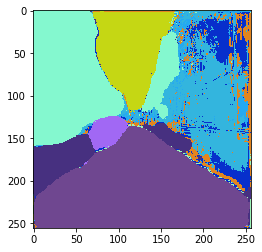

In [14]:
new_seg = _get_colored_segmentation_image(stacked_img, class_colors, 11)
plt.imshow(new_seg, interpolation='nearest')
plt.show()

In [15]:
img.shape

(256, 256, 3)

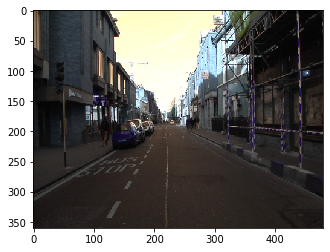

In [16]:
img = cv2.imread(image_train_filelist[0])
plt.imshow(img, interpolation='nearest')
plt.show()

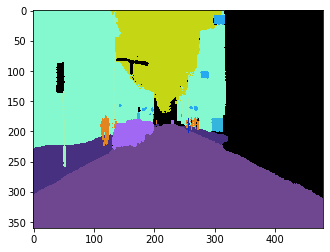

In [17]:
seg = cv2.imread(anno_train_filelist[0])
new_seg = _get_colored_segmentation_image(seg, class_colors, 11)
plt.imshow(new_seg, interpolation='nearest')
plt.show()